# Heat Exposure Prediction (Explainable ML + Spatial Block CV)

This notebook trains an **explainable** ML model to predict **seasonal mean temperature** (`mean_t`) from **urban form + greenness + land-use proxies**, and evaluates performance with:

- **Random KFold** (optimistic baseline)
- **Spatial Block CV** (reduces spatial leakage)
- (Optional) **Leave-location-out** CV using `id` groups

Dataset file: `data_output.csv`


In [3]:
# If running on Google Colab, uncomment:
# !pip -q install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
DATA_PATH = "data_output.csv"  # <- change if needed
TARGET = "mean_t"
LAT_COL, LON_COL = "LAT", "LON"
ID_COL = "id"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))
display(df.describe())

Shape: (1104, 70)


,id,year,season,Volume,mean_t,max_t,min_t,diff_t,gvi2,gvi3,...,park,leisure,bare,government,schools,social,public,DFM,SUM_h,cluster
0,n101,2018,spring,1342.443668,23.209104,27.577444,19.685497,7.891947,17.050438,0.109878,...,0.1013,0.0031,0.0123,0.0624,0.0665,0.0014,0.0005,31.042079,16.93482,2
1,n101,2019,spring,991.191114,22.112164,25.507568,19.450065,6.057503,17.050438,0.109878,...,0.1013,0.0031,0.0123,0.0624,0.0665,0.0014,0.0005,31.042079,16.93482,2
2,n101,2020,spring,980.955660,21.916302,25.458061,19.078187,6.379874,17.050438,0.109878,...,0.1013,0.0031,0.0123,0.0624,0.0665,0.0014,0.0005,31.042079,16.93482,2
3,n101,2021,spring,1802.089445,23.001712,26.848125,20.036032,6.812092,17.050438,0.109878,...,0.1013,0.0031,0.0123,0.0624,0.0665,0.0014,0.0005,31.042079,16.93482,2
4,n102,2018,spring,1161.877106,23.306125,27.591813,19.840415,7.751398,16.816805,0.106185,...,0.0835,0.0034,0.0098,0.0588,0.0364,0.0001,0.0303,28.852240,16.30374,1



Columns: ['id', 'year', 'season', 'Volume', 'mean_t', 'max_t', 'min_t', 'diff_t', 'gvi2', 'gvi3', 'svf', 'bvf', 'tvf', 'ndvi_modis', 'ndvi_l8', 'bu_sum', 'bu_mean', 'bu_median', 'pop_sum', 'pop_mean', 'pop_median', 'pop_stdev', 'bh_sum', 'bh_mean', 'bh_median', 'bh_stdev', 'bh_min', 'bh_max', 'bh_range', 'bu_area', 'LON', 'LAT', 'n_row', 'A_mean', 'A_median', 'A_stdev', 'A_min', 'A_max', 'A_range', 'S_mean', 'S_median', 'S_stdev', 'S_min', 'S_max', 'S_range', 'population', 'SUM_Area', 'SUM_volume', 'farm', 'forest', 'MRT', 'road', 'river', 'pool', 'business', 'live', 'mix', 'make', 'religion', 'funeral', 'park', 'leisure', 'bare', 'government', 'schools', 'social', 'public', 'DFM', 'SUM_h', 'cluster']


,year,Volume,mean_t,max_t,min_t,diff_t,gvi2,gvi3,svf,bvf,...,park,leisure,bare,government,schools,social,public,DFM,SUM_h,cluster
count,1104.000000,577.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,...,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1096.000000,1104.000000
mean,2019.500000,747.442424,21.512037,24.698845,19.012829,5.686016,30.171305,0.287595,42.664226,0.227392,...,0.044168,0.007074,0.013143,0.020431,0.044525,0.001022,0.002087,152.172092,10.334997,2.318841
std,1.118541,359.604179,2.943275,3.172545,2.823399,0.976242,14.356799,0.183221,11.492136,0.198266,...,0.056884,0.026971,0.022557,0.055729,0.080272,0.002287,0.004878,199.070140,5.594801,0.794227
min,2018.000000,17.155428,11.411838,14.095948,9.231672,3.908713,10.073482,0.033729,21.306552,0.000007,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.974103,2.999999,1.000000
25%,2018.750000,523.715409,18.881904,21.824615,16.652436,4.963023,17.822703,0.124103,34.747293,0.019744,...,0.002625,0.000000,0.003275,0.000000,0.000000,0.000000,0.000000,21.884362,4.619805,2.000000
50%,2019.500000,716.332990,22.269647,25.570501,19.543586,5.542792,24.893161,0.222676,39.545339,0.186397,...,0.021000,0.000450,0.007600,0.001700,0.016100,0.000100,0.000500,53.584115,10.280980,3.000000
75%,2020.250000,954.647665,23.438680,26.848040,20.663410,6.244455,41.874431,0.443880,47.151944,0.423719,...,0.065400,0.003400,0.013400,0.013650,0.058325,0.001000,0.001900,200.865807,14.465321,3.000000
max,2021.000000,2071.841524,30.408758,34.843245,27.234171,8.814465,64.396079,0.717494,88.871642,0.598600,...,0.325900,0.345300,0.268600,0.433600,0.697000,0.016500,0.038500,873.855049,22.925456,3.000000


In [5]:
# --- Basic checks ---
assert TARGET in df.columns, f"Target column {TARGET} not found"
assert LAT_COL in df.columns and LON_COL in df.columns, "LAT/LON columns not found"

print("Years:", sorted(df['year'].unique()) if 'year' in df.columns else "NA")
print("Seasons:", sorted(df['season'].unique()) if 'season' in df.columns else "NA")
print("Unique locations (id):", df[ID_COL].nunique() if ID_COL in df.columns else "NA")

missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(15))


Years: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]
Seasons: ['fall', 'spring', 'summer', 'winter']
Unique locations (id): 220


Volume        0.477355
ndvi_l8       0.083333
SUM_volume    0.007246
SUM_h         0.007246
year          0.000000
id            0.000000
max_t         0.000000
mean_t        0.000000
season        0.000000
min_t         0.000000
svf           0.000000
bvf           0.000000
gvi2          0.000000
diff_t        0.000000
ndvi_modis    0.000000
dtype: float64

In [6]:
# --- Feature set ---
DROP_COLS = [TARGET, 'max_t','min_t','diff_t', LAT_COL, LON_COL]  # avoid leakage from other temperature vars + coordinates
if ID_COL in df.columns:
    DROP_COLS.append(ID_COL)

X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
y = df[TARGET].to_numpy()

cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

print("Num features:", len(num_cols))
print("Cat features:", cat_cols)


Num features: 62
Cat features: ['season']


Spatial blocks: 66


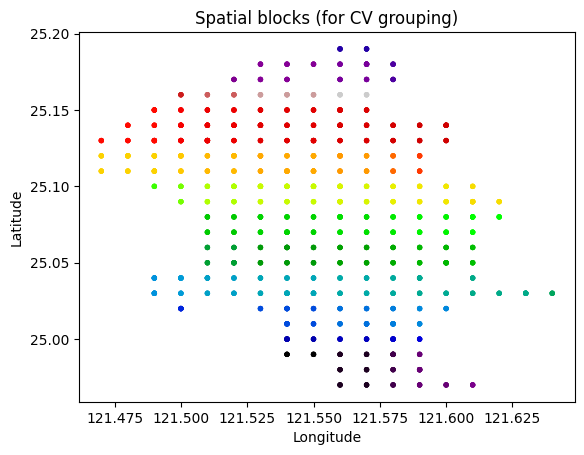

In [22]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

preprocess = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median'))]), num_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                      ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
])

def make_spatial_blocks(df, block_deg=0.02, lat_col=LAT_COL, lon_col=LON_COL):
    latmin, lonmin = df[lat_col].min(), df[lon_col].min()
    bid = (np.floor((df[lat_col]-latmin)/block_deg).astype(int).astype(str) + "_" +
           np.floor((df[lon_col]-lonmin)/block_deg).astype(int).astype(str))
    return bid

blocks = make_spatial_blocks(df, block_deg=0.02)
print("Spatial blocks:", blocks.nunique())

# quick visual: blocks on map
plt.figure()
plt.scatter(
    df[LON_COL], 
    df[LAT_COL], 
    c=blocks.astype('category').cat.codes, 
    s=8, 
    cmap='nipy_spectral'
)
plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.title("Spatial blocks (for CV grouping)")
plt.savefig("outputs/blocks_map.png", dpi=300, bbox_inches="tight")
plt.show()


In [23]:
def cv_predict_regression(df, X, y, cv, groups=None, seed=42):
    preds = np.empty_like(y, dtype=float)
    for tr, te in cv.split(X, y, groups):
        model = RandomForestRegressor(
            n_estimators=120, random_state=seed, n_jobs=1,
            max_features='sqrt', min_samples_leaf=2
        )
        pipe = Pipeline([('prep', preprocess), ('model', model)])
        pipe.fit(X.iloc[tr], y[tr])
        preds[te] = pipe.predict(X.iloc[te])
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    return rmse, mae, r2, preds

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
gkf = GroupKFold(n_splits=5)

rmse_k, mae_k, r2_k, pred_k = cv_predict_regression(df, X, y, kfold, None)
rmse_b, mae_b, r2_b, pred_b = cv_predict_regression(df, X, y, gkf, blocks)

print("Random KFold   RMSE:", rmse_k, "MAE:", mae_k, "R2:", r2_k)
print("Spatial Block  RMSE:", rmse_b, "MAE:", mae_b, "R2:", r2_b)


Random KFold   RMSE: 0.6116565315653407 MAE: 0.5013721848493817 R2: 0.9567737823637276
Spatial Block  RMSE: 1.155109489873301 MAE: 0.8210650984226588 R2: 0.8458376563649547


In [24]:
# Optional: Leave-location-out CV (stricter, groups by id)
if ID_COL in df.columns:
    gid = df[ID_COL]
    rmse_id, mae_id, r2_id, pred_id = cv_predict_regression(df, X, y, gkf, gid)
    print("Leave-location-out RMSE:", rmse_id, "MAE:", mae_id, "R2:", r2_id)
else:
    rmse_id = mae_id = r2_id = None


Leave-location-out RMSE: 1.1558688841087787 MAE: 0.8130580820443694 R2: 0.8456348903444204


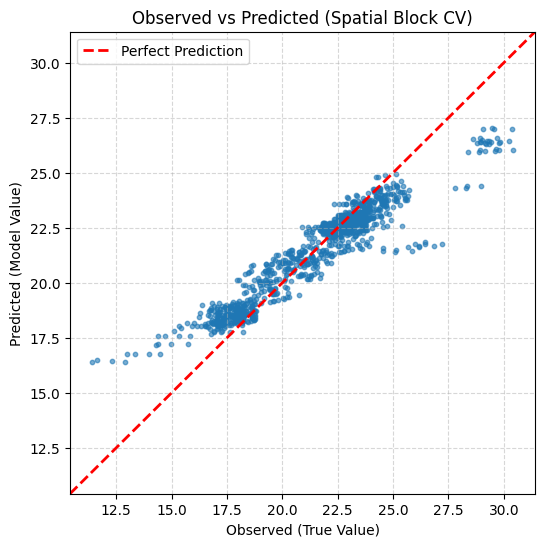

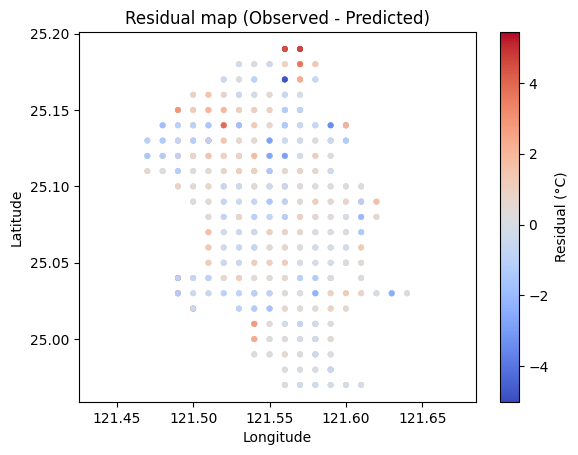

In [25]:
# --- Diagnostic plots (Block CV) ---
plt.figure(figsize=(6, 6))

#get the right x,y limits
all_min = min(y.min(), pred_b.min()) - 1
all_max = max(y.max(), pred_b.max()) + 1

plt.scatter(y, pred_b, s=10, alpha=0.6) 

# draw a red line for perfect predict
plt.plot([all_min, all_max], [all_min, all_max], 'r--', lw=2, label="Perfect Prediction")

plt.xlim(all_min, all_max)
plt.ylim(all_min, all_max)
plt.xlabel("Observed (True Value)")
plt.ylabel("Predicted (Model Value)")
plt.title("Observed vs Predicted (Spatial Block CV)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5) 
plt.savefig("outputs/Diagnostic_plots (Block CV).png", dpi=300, bbox_inches="tight")
plt.show()

#Residual map
plt.figure()
plt.scatter(df[LON_COL], df[LAT_COL], c=residual, s=10, cmap='coolwarm') 
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Residual map (Observed - Predicted)")
plt.colorbar(label="Residual (°C)")

plt.axis('equal') 
plt.savefig("outputs/Residual_map.png", dpi=300, bbox_inches="tight")

plt.show()


,feature,importance_mean,importance_std
1,season,2.701455,0.076426
26,A_mean,0.180966,0.015119
27,A_median,0.173238,0.013594
60,DFM,0.165897,0.012719
29,A_min,0.150685,0.010596
0,year,0.123294,0.005311
30,A_max,0.114046,0.008053
8,ndvi_modis,0.106180,0.010261
9,ndvi_l8,0.086584,0.006640
6,bvf,0.055312,0.002922


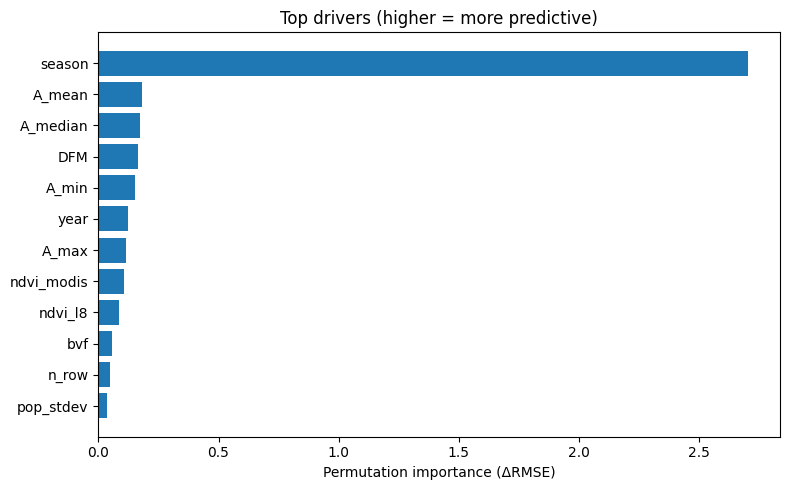

In [26]:
# --- Explainability: permutation importance (planning-relevant drivers) ---
from sklearn.inspection import permutation_importance

# Fit on all data for interpretability (not used for evaluation)
final_model = Pipeline([('prep', preprocess),
                        ('model', RandomForestRegressor(
                            n_estimators=200, random_state=42, n_jobs=1,
                            max_features='sqrt', min_samples_leaf=2
                        ))])
final_model.fit(X, y)

# run importance on a subset for speed
idx = np.random.RandomState(42).choice(len(X), size=min(600, len(X)), replace=False)
pi = permutation_importance(final_model, X.iloc[idx], y[idx], n_repeats=15,
                            random_state=42, n_jobs=1, scoring='neg_root_mean_squared_error')

imp = pd.DataFrame({'feature': X.columns,
                    'importance_mean': pi.importances_mean,
                    'importance_std': pi.importances_std}).sort_values('importance_mean', ascending=False)

display(imp.head(20))

plt.figure(figsize=(8,5))
top = imp.head(12).iloc[::-1]
plt.barh(top['feature'], top['importance_mean'])
plt.xlabel("Permutation importance (ΔRMSE)")
plt.title("Top drivers (higher = more predictive)")
plt.tight_layout()
plt.savefig("outputs/importance_plot.png", dpi=300, bbox_inches="tight")
plt.show()


In [27]:
# --- Export summary for 1-page PDF / README ---
summary = {
    "dataset_rows": int(df.shape[0]),
    "dataset_cols": int(df.shape[1]),
    "unique_locations": int(df[ID_COL].nunique()) if ID_COL in df.columns else None,
    "target": TARGET,
    "random_kfold": {"rmse": float(rmse_k), "mae": float(mae_k), "r2": float(r2_k)},
    "spatial_block_cv": {"rmse": float(rmse_b), "mae": float(mae_b), "r2": float(r2_b)},
    "leave_location_out": None if ID_COL not in df.columns else {"rmse": float(rmse_id), "mae": float(mae_id), "r2": float(r2_id)},
    "top_features": imp.head(12).to_dict(orient='records')
}

import json, os
os.makedirs("outputs", exist_ok=True)
with open("outputs/summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved outputs/summary.json")


Saved outputs/summary.json
